<a href="https://colab.research.google.com/github/rokugatsu/titanic_kaggle/blob/main/Competition01_based_240608_estimate_age_by_RF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

submission_kaggle - 2024-06-08T031954.161.csv Score: 0.79665
#0. ライブラリ・データ読み込み

In [946]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [947]:
import numpy as np
import pandas as pd
from pandas import DataFrame, Series
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier

import lightgbm as lgb

import warnings
warnings.filterwarnings('ignore')

In [948]:
# 読み込むデータが格納されたディレクトリのパス，必要に応じて変更の必要あり
# データの読み込み方がわからない方は、別途配布している、GoogleColabにおけるドライブのマウントの仕方、と、Google Drive上でのフォルダ構造の説明のpdfファイルをご覧ください。
#path = "/content/drive/My Drive/Colab Notebooks/GCI_2024_Summer/Competitions/competition_1/"
path = "/content/drive/MyDrive/data/"

#df = pd.read_csv(path + 'data/train.csv')
#df_test = pd.read_csv(path + 'data/test.csv')

df_train = pd.read_csv(path + 'train.csv')
df_test = pd.read_csv(path + 'test.csv')

df_all = pd.concat([df_train, df_test])

In [949]:
print(df_train.shape)
df_train.head()
df_train

(891, 12)


,PassengerId,Perished,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,1,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,1,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,0,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,1,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,0,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


#1. データの概観・分析・前処理

In [950]:
print('訓練データのデータ数は{}、変数は{}種類です。'.format(df_train.shape[0], df_train.shape[1]))
print('テストデータのデータ数は{}、変数は{}種類です'.format(df_test.shape[0], df_test.shape[1]))

訓練データのデータ数は891、変数は12種類です。
テストデータのデータ数は418、変数は11種類です


In [951]:
df_train.columns

Index(['PassengerId', 'Perished', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [952]:
df_train.isnull().sum()

PassengerId      0
Perished         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [953]:
df_test.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

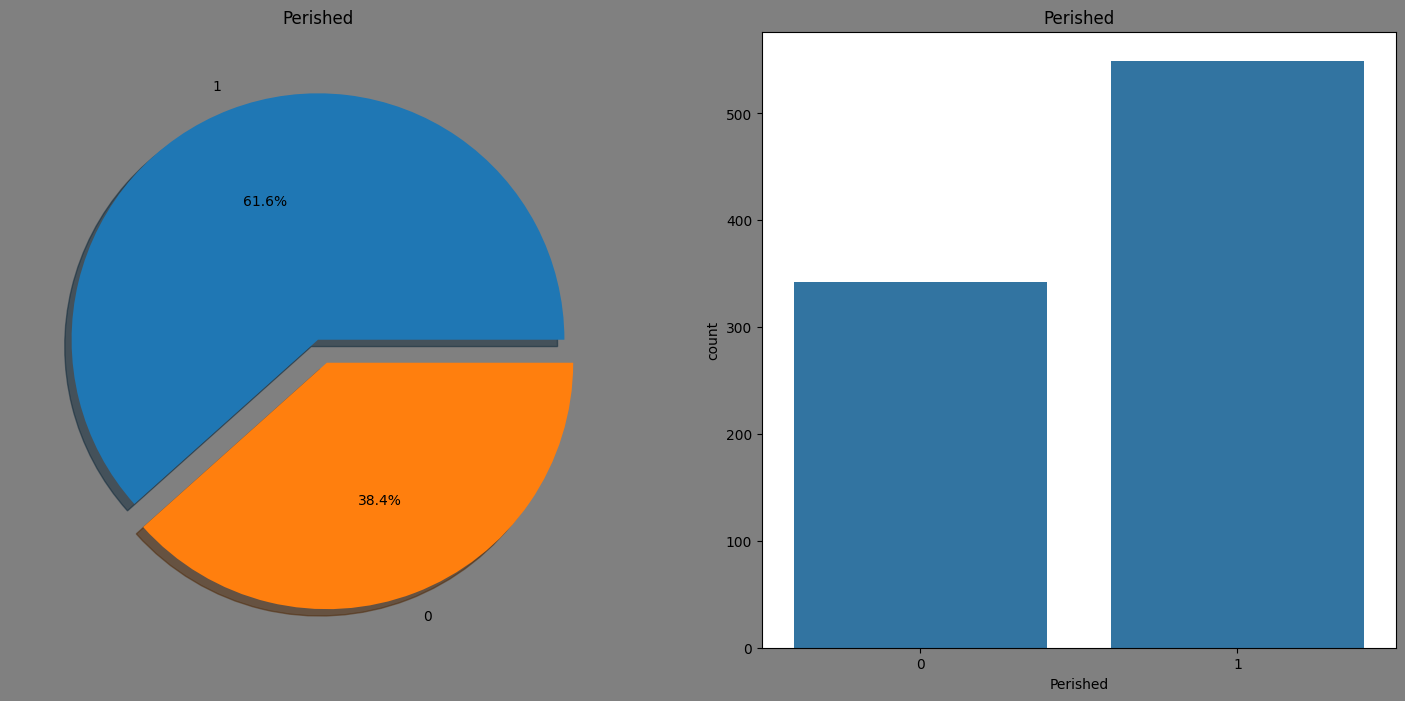

In [954]:
f,ax=plt.subplots(1,2,figsize=(18,8), facecolor='gray')
df_train['Perished'].value_counts().plot.pie(explode=[0,0.1],autopct='%1.1f%%',ax=ax[0],shadow=True)
ax[0].set_title('Perished')
ax[0].set_ylabel('')
sns.countplot(x='Perished',data=df_train,ax=ax[1])
ax[1].set_title('Perished')
plt.show()

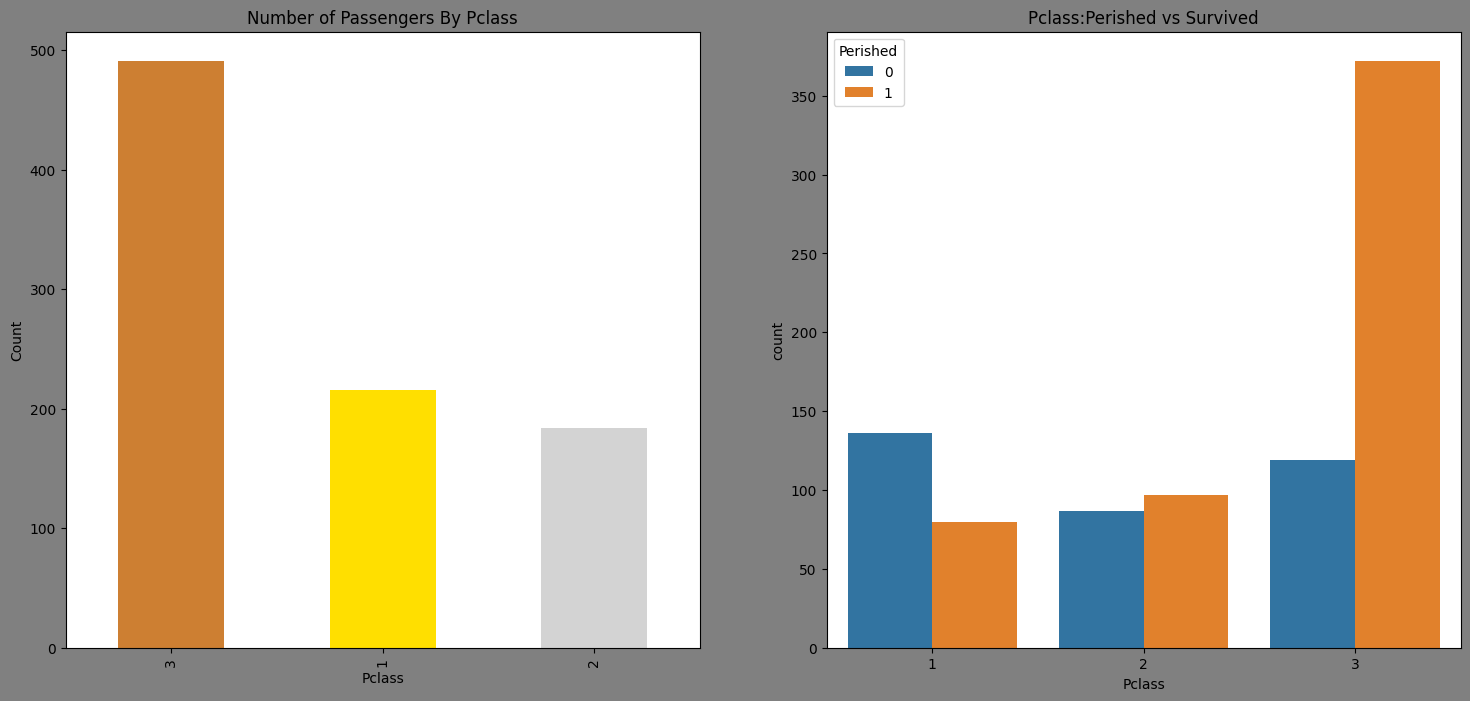

In [955]:
f,ax=plt.subplots(1,2,figsize=(18,8), facecolor='gray')
df_train['Pclass'].value_counts().plot.bar(color=['#CD7F32','#FFDF00','#D3D3D3'],ax=ax[0])
ax[0].set_title('Number of Passengers By Pclass')
ax[0].set_ylabel('Count')
sns.countplot(x='Pclass',hue='Perished',data=df_train,ax=ax[1])
ax[1].set_title('Pclass:Perished vs Survived')
plt.show()

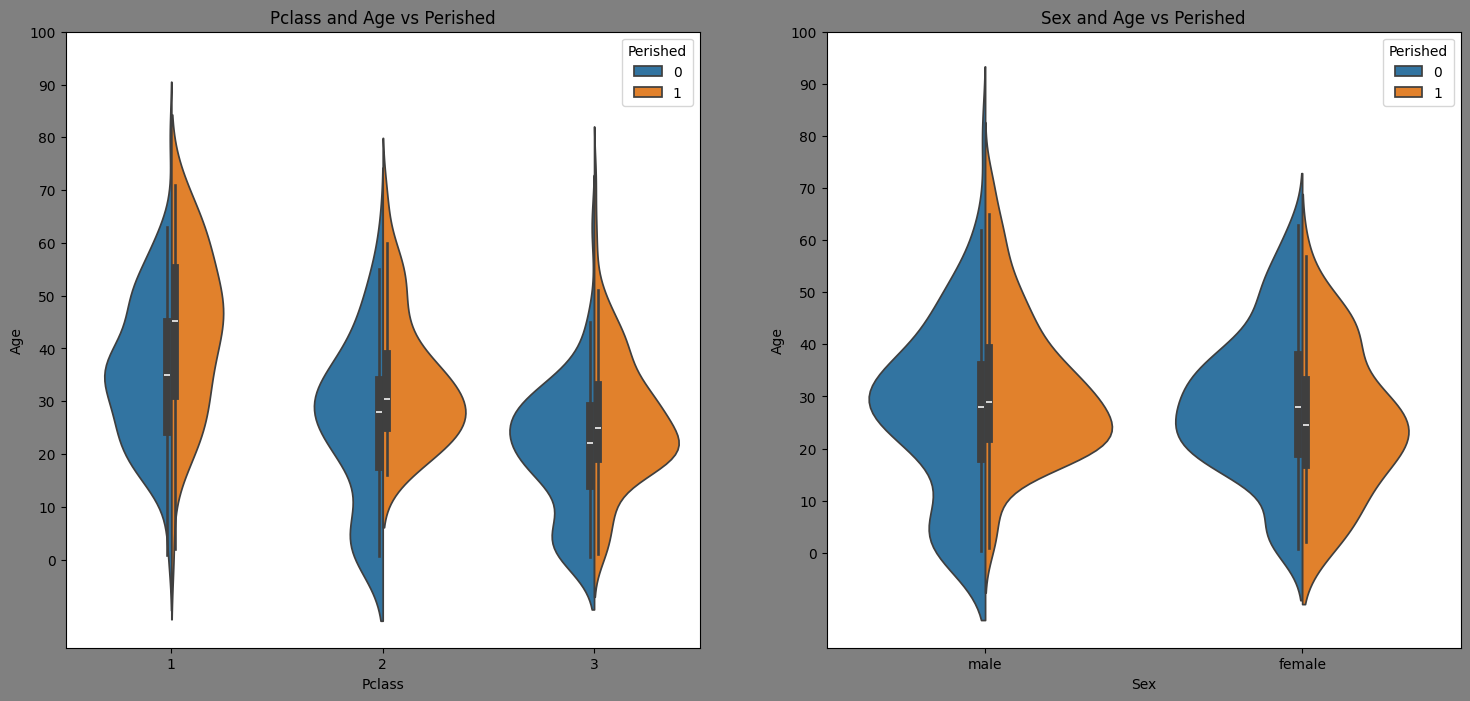

In [956]:
f,ax=plt.subplots(1,2,figsize=(18,8), facecolor='gray')
sns.violinplot(x="Pclass",y="Age", hue="Perished", data=df_train,split=True,ax=ax[0])
ax[0].set_title('Pclass and Age vs Perished')
ax[0].set_yticks(range(0,110,10))
sns.violinplot(x="Sex",y="Age", hue="Perished", data=df_train,split=True,ax=ax[1])
ax[1].set_title('Sex and Age vs Perished')
ax[1].set_yticks(range(0,110,10))
plt.show()

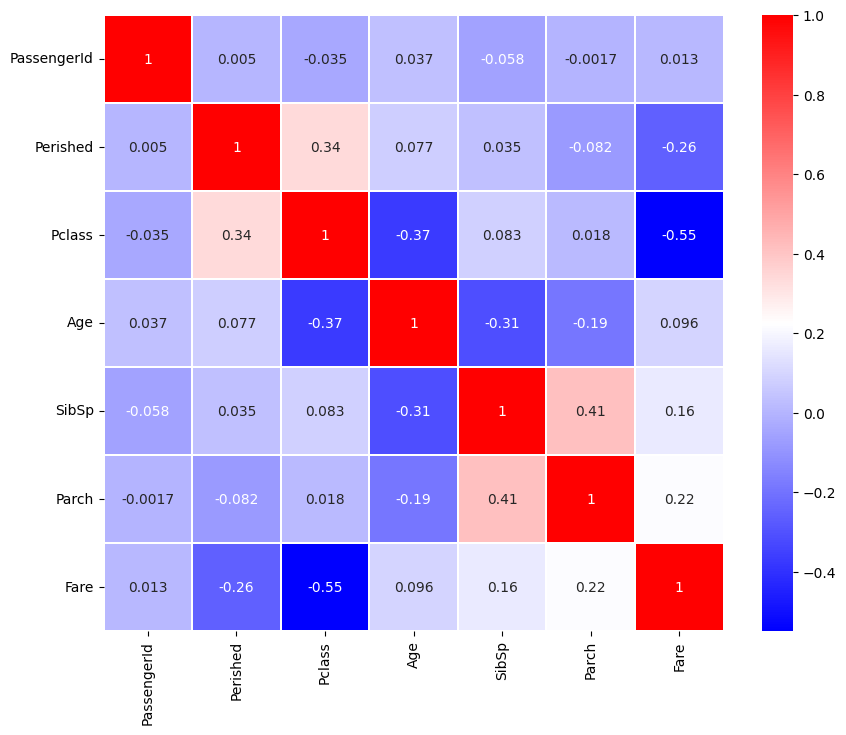

In [957]:
df_numeric = df_train.select_dtypes(include=['number'])
sns.heatmap(df_numeric.corr(),annot=True,cmap='bwr',linewidths=0.2)
fig=plt.gcf()
fig.set_size_inches(10,8)
plt.show()

In [958]:
df_all = pd.concat([df_train, df_test])

,PassengerId,Perished,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,1.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,0.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,0.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,0.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,1.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,NaN,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
414,1306,NaN,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
415,1307,NaN,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
416,1308,NaN,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


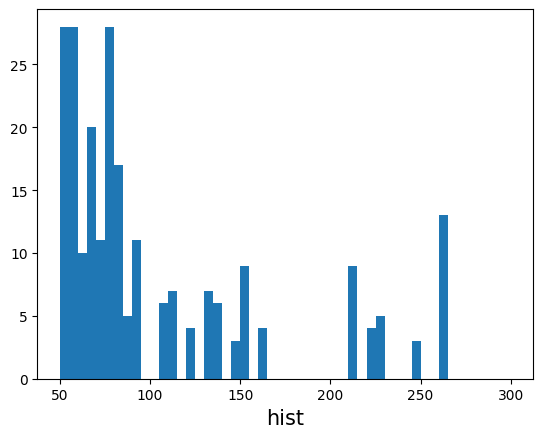

In [959]:
# ヒストグラムの描写
# x軸のラベルを指定
plt.xlabel('Fare', fontsize=15)
plt.xlabel('hist', fontsize=15)

#plt.hist(x=df['sepal_length'], bins=25, range=(4.5, 7.5))
plt.hist(x=df_all['Fare'], bins=50, range=(50, 300))
df_all.loc[(df_all['Fare'].values > 200), "Pclass"] = 0

df_all

In [960]:
df_test

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


In [961]:
df_train

,PassengerId,Perished,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,1,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,1,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,0,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,1,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,0,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


,PassengerId,Perished,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,1,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,1,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,0,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,1,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,0,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


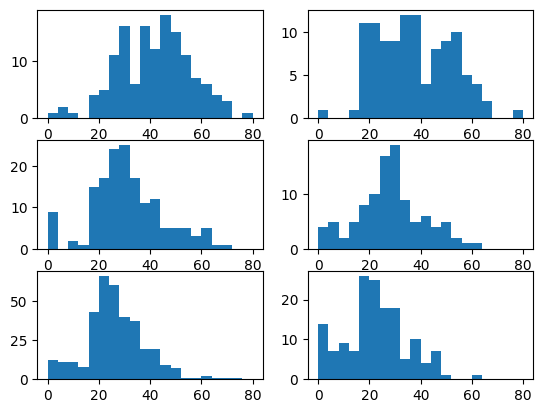

In [962]:
#df_all = pd.concat([df_train, df_test])

# ヒストグラムの描写
# x軸のラベルを指定
#plt.xlabel('FareSingle', fontsize=15)
#plt.xlabel('hist', fontsize=15)

#plt.hist(x=df['sepal_length'], bins=25, range=(4.5, 7.5))
#plt.hist(x=df_all[df_all['Pclass']==0].Fare, bins=50, range=(0, 200))
#plt.hist(x=df_all[df_all['Pclass']==1].Fare, bins=50, range=(0, 200))
#plt.hist(x=df_all[df_all['Pclass']==2].Fare, bins=50, range=(0, 200))
#plt.hist(x=df_all[df_all['Pclass']==3].Fare, bins=50, range=(0, 200))
plt.subplot(3,2,1,label="Class1:male")
plt.hist(x=df_all[(df_all['Pclass']==1) & (df_all['Sex']=='male')].Age, bins=20, range=(0, 80))

plt.subplot(3,2,2)
plt.hist(x=df_all[(df_all['Pclass']==1) & (df_all['Sex']=='female')].Age, bins=20, range=(0, 80),label='Class1:female')

plt.subplot(3,2,3)
plt.hist(x=df_all[(df_all['Pclass']==2) & (df_all['Sex']=='male')].Age, bins=20, range=(0, 80),label="Class2:male")

plt.subplot(3,2,4)
plt.hist(x=df_all[(df_all['Pclass']==2) & (df_all['Sex']=='female')].Age, bins=20, range=(0, 80),label="Class2:male")

plt.subplot(3,2,5)
plt.hist(x=df_all[(df_all['Pclass']==3) & (df_all['Sex']=='male')].Age, bins=20, range=(0, 80),label="Class3:male")

plt.subplot(3,2,6)
plt.hist(x=df_all[(df_all['Pclass']==3) & (df_all['Sex']=='female')].Age, bins=20, range=(0, 80),label="Class3:female")

#plt.hist(x=df_all[df_all['Pclass']==1].Fare, bins=50, range=(0, 200))
#plt.hist(x=df_all[df_all['Pclass']==2].Fare, bins=50, range=(0, 200))
#plt.hist(x=df_all[df_all['Pclass']==3].Fare, bins=50, range=(0, 200))

df_train

In [963]:
from sklearn.ensemble import RandomForestRegressor

# 推定に使用する項目を指定
age_df = df_all[['Age', 'Pclass','Sex','Parch','SibSp']]

# ラベル特徴量をワンホットエンコーディング
age_df=pd.get_dummies(age_df)

# 学習データとテストデータに分離し、numpyに変換
known_age = age_df[age_df.Age.notnull()].values
unknown_age = age_df[age_df.Age.isnull()].values

# 学習データをX, yに分離
#X = known_age[:, 1:]
#y = known_age[:, 0]

X_age = known_age[:, 1:]
y_age = known_age[:, 0]

age_df

,Age,Pclass,Parch,SibSp,Sex_female,Sex_male
0,22.0,3,0,1,False,True
1,38.0,1,0,1,True,False
2,26.0,3,0,0,True,False
3,35.0,1,0,1,True,False
4,35.0,3,0,0,False,True
...,...,...,...,...,...,...
413,NaN,3,0,0,False,True
414,39.0,1,0,0,True,False
415,38.5,3,0,0,False,True
416,NaN,3,0,0,False,True


In [964]:
X_age

array([[3, 0, 1, False, True],
       [1, 0, 1, True, False],
       [3, 0, 0, True, False],
       ...,
       [3, 0, 0, True, False],
       [1, 0, 0, True, False],
       [3, 0, 0, False, True]], dtype=object)

In [965]:
y_age

array([22.0, 38.0, 26.0, ..., 28.0, 39.0, 38.5], dtype=object)

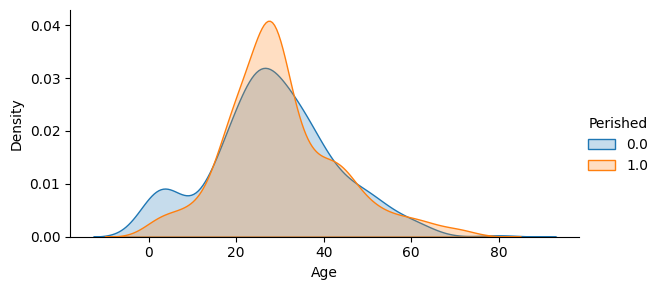

In [966]:
#print(X)
#print(y)

# ランダムフォレストで推定モデルを構築 RandomForestClassifier(random_state=42)
#rfc = RandomForestClassifier(max_depth=20, min_samples_leaf=1, n_estimators=100, n_jobs=-1, random_state=42)
#rfc.fit(X_train, y_train)
#rfc = RandomForestClassifier(random_state=42, n_estimators=100, n_jobs=-1)

#rfc = RandomForestClassifier(max_depth=20, min_samples_leaf=1, n_estimators=100, n_jobs=-1, random_state=42)
rfr = RandomForestRegressor(random_state=0, n_estimators=100, n_jobs=-1)
rfr.fit(X_age, y_age)

# 推定モデルを使って、テストデータのAgeを予測し、補完
predictedAges = rfr.predict(unknown_age[:, 1::])
df_all.loc[(df_all.Age.isnull()), 'Age'] = predictedAges

# 年齢別生存曲線と死亡曲線
facet = sns.FacetGrid(df_all[0:890], hue="Perished",aspect=2)
facet.map(sns.kdeplot,'Age',shade= True)
#facet.set(xlim=(0, df_all.loc[0:890,'Age'].max()))
facet.add_legend()
plt.show()

Pclass 分類．特１等室=0.5, Fare > 200

In [967]:
df_train = df_all[:891]
df_test = df_all[891:]

In [968]:
df_test

,PassengerId,Perished,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,NaN,3,"Kelly, Mr. James",male,34.500000,0,0,330911,7.8292,NaN,Q
1,893,NaN,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.000000,1,0,363272,7.0000,NaN,S
2,894,NaN,2,"Myles, Mr. Thomas Francis",male,62.000000,0,0,240276,9.6875,NaN,Q
3,895,NaN,3,"Wirz, Mr. Albert",male,27.000000,0,0,315154,8.6625,NaN,S
4,896,NaN,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.000000,1,1,3101298,12.2875,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,NaN,3,"Spector, Mr. Woolf",male,28.421211,0,0,A.5. 3236,8.0500,NaN,S
414,1306,NaN,1,"Oliva y Ocana, Dona. Fermina",female,39.000000,0,0,PC 17758,108.9000,C105,C
415,1307,NaN,3,"Saether, Mr. Simon Sivertsen",male,38.500000,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
416,1308,NaN,3,"Ware, Mr. Frederick",male,28.421211,0,0,359309,8.0500,NaN,S


In [969]:
df_train

,PassengerId,Perished,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,1.0,3,"Braund, Mr. Owen Harris",male,22.000000,1,0,A/5 21171,7.2500,NaN,S
1,2,0.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.000000,1,0,PC 17599,71.2833,C85,C
2,3,0.0,3,"Heikkinen, Miss. Laina",female,26.000000,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,0.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000000,1,0,113803,53.1000,C123,S
4,5,1.0,3,"Allen, Mr. William Henry",male,35.000000,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,1.0,2,"Montvila, Rev. Juozas",male,27.000000,0,0,211536,13.0000,NaN,S
887,888,0.0,1,"Graham, Miss. Margaret Edith",female,19.000000,0,0,112053,30.0000,B42,S
888,889,1.0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,16.906145,1,2,W./C. 6607,23.4500,NaN,S
889,890,0.0,1,"Behr, Mr. Karl Howell",male,26.000000,0,0,111369,30.0000,C148,C


In [970]:
fare_Pclass0_Mean = df_all[df_all.Pclass==0].Fare.mean()
fare_Pclass1_Mean = df_all[df_all.Pclass==1].Fare.mean()
fare_Pclass2_Mean = df_all[df_all.Pclass==2].Fare.mean()
fare_Pclass3_Mean = df_all[df_all.Pclass==3].Fare.mean()

print("fare_Pclass0_Mean:",fare_Pclass0_Mean)
print("fare_Pclass1_Mean:",fare_Pclass1_Mean)
print("fare_Pclass2_Mean:",fare_Pclass2_Mean)
print("fare_Pclass3_Mean:",fare_Pclass3_Mean)

df_train.loc[(df_train['Pclass'] == 0) & ((df_train['Fare'].values == 0) | (df_train['Fare'].isnull())),'Fare'] =  fare_Pclass0_Mean
df_train.loc[(df_train['Pclass'] == 1) & ((df_train['Fare'].values == 0) | (df_train['Fare'].isnull())),'Fare'] =  fare_Pclass1_Mean
df_train.loc[(df_train['Pclass'] == 2) & ((df_train['Fare'].values == 0) | (df_train['Fare'].isnull())),'Fare'] =  fare_Pclass2_Mean
df_train.loc[(df_train['Pclass'] == 3) & ((df_train['Fare'].values == 0) | (df_train['Fare'].isnull())),'Fare'] =  fare_Pclass3_Mean

df_test.loc[(df_test['Pclass'] == 0) & ((df_test['Fare'].values == 0) | (df_test['Fare'].isnull())),'Fare'] =  fare_Pclass0_Mean
df_test.loc[(df_test['Pclass'] == 1) & ((df_test['Fare'].values == 0) | (df_test['Fare'].isnull())),'Fare'] =  fare_Pclass1_Mean
df_test.loc[(df_test['Pclass'] == 2) & ((df_test['Fare'].values == 0) | (df_test['Fare'].isnull())),'Fare'] =  fare_Pclass2_Mean
df_test.loc[(df_test['Pclass'] == 3) & ((df_test['Fare'].values == 0) | (df_test['Fare'].isnull())),'Fare'] =  fare_Pclass3_Mean

fare_Pclass0_Mean: 266.68673684210523
fare_Pclass1_Mean: 63.61862561403509
fare_Pclass2_Mean: 21.1791963898917
fare_Pclass3_Mean: 13.302888700564973


In [971]:
#df_train['FareSingle'] = df_train.Fare/(df_train.SibSp+df_train.Parch+1)
#df_test['FareSingle'] = df_test.Fare/(df_test.SibSp+df_test.Parch+1)

In [972]:
print(df_train.isnull().sum())
print(df_test.isnull().sum())

PassengerId      0
Perished         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64
PassengerId      0
Perished       418
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          327
Embarked         0
dtype: int64


In [973]:
#df_train.drop('Cabin', axis=1, inplace=True)
#df_test.drop('Cabin', axis=1, inplace=True)

#df_train.isnull().sum()

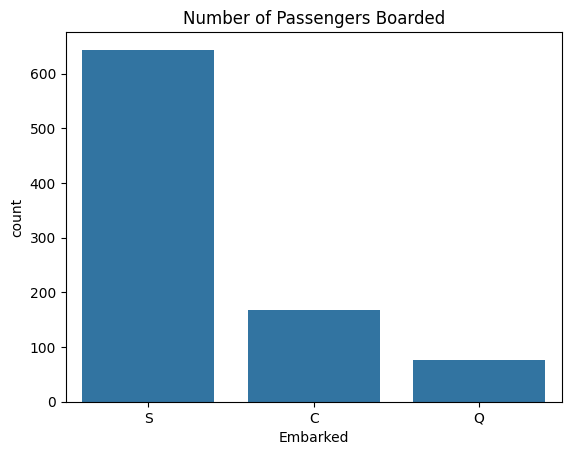

In [974]:
sns.countplot(x='Embarked',data=df_train)
plt.title('Number of Passengers Boarded')
plt.show()

In [975]:
df_all['Embarked'].fillna('S', inplace=True)
df_all.isnull().sum()

PassengerId       0
Perished        418
Pclass            0
Name              0
Sex               0
Age               0
SibSp             0
Parch             0
Ticket            0
Fare              0
Cabin          1014
Embarked          0
dtype: int64

In [976]:
df_all.drop('Name', axis=1, inplace=True)
#df_all.drop('Ticket', axis=1, inplace=True)

df_all.columns

Index(['PassengerId', 'Perished', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [977]:
df_all.replace({'Sex': {'male': 0, 'female': 1}}, inplace=True)
df_all
#df.head()

,PassengerId,Perished,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,1.0,3,0,22.000000,1,0,A/5 21171,7.2500,NaN,S
1,2,0.0,1,1,38.000000,1,0,PC 17599,71.2833,C85,C
2,3,0.0,3,1,26.000000,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,0.0,1,1,35.000000,1,0,113803,53.1000,C123,S
4,5,1.0,3,0,35.000000,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
413,1305,NaN,3,0,28.421211,0,0,A.5. 3236,8.0500,NaN,S
414,1306,NaN,1,1,39.000000,0,0,PC 17758,108.9000,C105,C
415,1307,NaN,3,0,38.500000,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
416,1308,NaN,3,0,28.421211,0,0,359309,8.0500,NaN,S


In [978]:
embarked = df_all['Embarked']
embarked
embarked_ohe = pd.get_dummies(embarked)
embarked_ohe

df_all.drop('Embarked', axis=1, inplace=True)

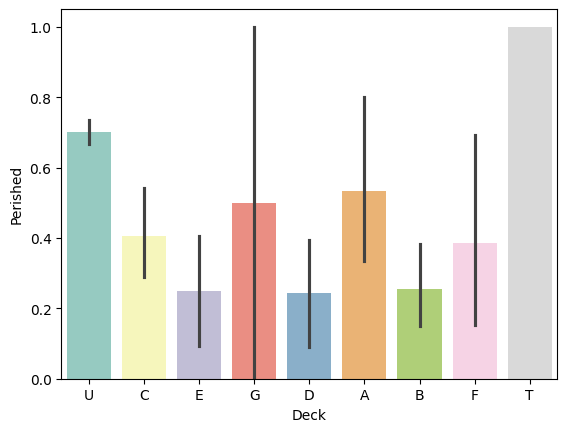

In [979]:
# 客室階層による生存率比較
df_train['Cabin'] = df_train['Cabin'].fillna('Unknown') # 客室データが欠損している場合はUnknownを代入
df_train['Deck'] = df_train['Cabin'].str.get(0) #Cabin（部屋番号）の頭文字（０番目の文字）取得
sns.barplot(x="Deck", y="Perished", data=df_train, palette='Set3')

df_all['Cabin'] = df_all['Cabin'].fillna('Unknown') # 客室データが欠損している場合はUnknownを代入

In [980]:
#df_all.drop('Deck',  axis=1, inplace=True)

In [981]:
#df_train.loc[df_train["Deck"].values =='T',"Deck"] = 1
#df_train.loc[df_train["Deck"].values =='A',"Deck"] = 2
#df_train.loc[df_train["Deck"].values =='B',"Deck"] = 3
#df_train.loc[df_train["Deck"].values =='C',"Deck"] = 4
#df_train.loc[df_train["Deck"].values =='D',"Deck"] = 5
#df_train.loc[df_train["Deck"].values =='E',"Deck"] = 6
#df_train.loc[df_train["Deck"].values =='F',"Deck"] = 7
#df_train.loc[df_train["Deck"].values =='G',"Deck"] = 8
#df_train.loc[df_train["Deck"].values =='U',"Deck"] = 9

#df_test.loc[df_test["Deck"].values =='T',"Deck"] = 1
#df_test.loc[df_test["Deck"].values =='A',"Deck"] = 2
#df_test.loc[df_test["Deck"].values =='B',"Deck"] = 3
#df_test.loc[df_test["Deck"].values =='C',"Deck"] = 4
#df_test.loc[df_test["Deck"].values =='D',"Deck"] = 5
#df_test.loc[df_test["Deck"].values =='E',"Deck"] = 6
#df_test.loc[df_test["Deck"].values =='F',"Deck"] = 7
#df_test.loc[df_test["Deck"].values =='G',"Deck"] = 8
#df_test.loc[df_test["Deck"].values =='U',"Deck"] = 9

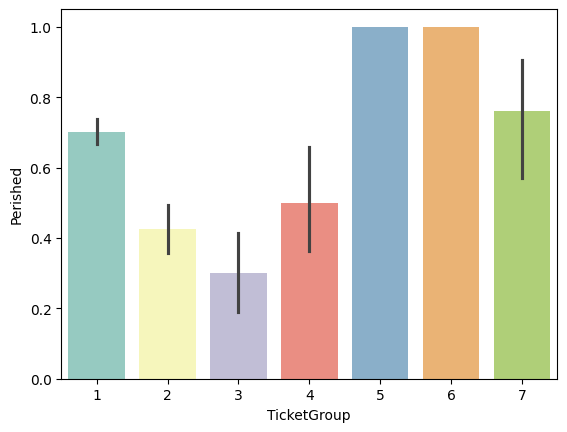

In [982]:
# チケットの文字数による生存率比較
Ticket_Count = dict(df_train['Ticket'].value_counts()) # チケットの文字数でグループ分け
df_train['TicketGroup'] = df_train['Ticket'].apply(lambda x:Ticket_Count[x]) # グループの振り分け
sns.barplot(x='TicketGroup', y='Perished', data=df_train, palette='Set3')

Ticket_Count_all = dict(df_all['Ticket'].value_counts()) # チケットの文字数でグループ分け
df_all['TicketGroup'] = df_all['Ticket'].apply(lambda x:Ticket_Count_all[x]) # グループの振り分け

In [983]:
df_all

,PassengerId,Perished,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,TicketGroup
0,1,1.0,3,0,22.000000,1,0,A/5 21171,7.2500,Unknown,1
1,2,0.0,1,1,38.000000,1,0,PC 17599,71.2833,C85,2
2,3,0.0,3,1,26.000000,0,0,STON/O2. 3101282,7.9250,Unknown,1
3,4,0.0,1,1,35.000000,1,0,113803,53.1000,C123,2
4,5,1.0,3,0,35.000000,0,0,373450,8.0500,Unknown,1
...,...,...,...,...,...,...,...,...,...,...,...
413,1305,NaN,3,0,28.421211,0,0,A.5. 3236,8.0500,Unknown,1
414,1306,NaN,1,1,39.000000,0,0,PC 17758,108.9000,C105,3
415,1307,NaN,3,0,38.500000,0,0,SOTON/O.Q. 3101262,7.2500,Unknown,1
416,1308,NaN,3,0,28.421211,0,0,359309,8.0500,Unknown,1


In [984]:
df_all['TicketGroup2'] = 2
df_all.loc[(df_all['TicketGroup'].values== 2) | (df_all['TicketGroup'].values== 3) | (df_all['TicketGroup'].values == 4) , "TicketGroup2"] = 1
df_all

df_all.drop('Ticket',  axis=1, inplace=True)
df_all.drop('TicketGroup',  axis=1, inplace=True)

In [985]:
#df_train.drop('Fare', axis=1, inplace=True)
#df_test.drop('Fare', axis=1, inplace=True)
#df_train.drop('FareSingle', axis=1, inplace=True)
#df_test.drop('FareSingle', axis=1, inplace=True)

In [986]:
df_all.drop('Cabin',  axis=1, inplace=True)

In [987]:
df_train

,PassengerId,Perished,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Deck,TicketGroup
0,1,1.0,3,"Braund, Mr. Owen Harris",male,22.000000,1,0,A/5 21171,7.2500,Unknown,S,U,1
1,2,0.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.000000,1,0,PC 17599,71.2833,C85,C,C,1
2,3,0.0,3,"Heikkinen, Miss. Laina",female,26.000000,0,0,STON/O2. 3101282,7.9250,Unknown,S,U,1
3,4,0.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000000,1,0,113803,53.1000,C123,S,C,2
4,5,1.0,3,"Allen, Mr. William Henry",male,35.000000,0,0,373450,8.0500,Unknown,S,U,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,1.0,2,"Montvila, Rev. Juozas",male,27.000000,0,0,211536,13.0000,Unknown,S,U,1
887,888,0.0,1,"Graham, Miss. Margaret Edith",female,19.000000,0,0,112053,30.0000,B42,S,B,1
888,889,1.0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,16.906145,1,2,W./C. 6607,23.4500,Unknown,S,U,2
889,890,0.0,1,"Behr, Mr. Karl Howell",male,26.000000,0,0,111369,30.0000,C148,C,C,1


In [988]:
#df_train['Family']=  df_train['SibSp'] + df_train['Parch'] + 1
#df_test['Family'] =  df_test['SibSp'] + df_test['Parch'] +1

#df_train.drop('SibSp', axis=1, inplace=True)
#df_test.drop('SibSp', axis=1, inplace=True)

#df_train.drop('Parch', axis=1, inplace=True)
#df_test.drop('Parch', axis=1, inplace=True)


In [989]:
df_all['FamilySibSp']=  df_all['SibSp'] / (df_all['SibSp'] + df_all['Parch']+1)

#Data devide again

In [990]:
df_train = df_all[:891]
df_test = df_all[891:]

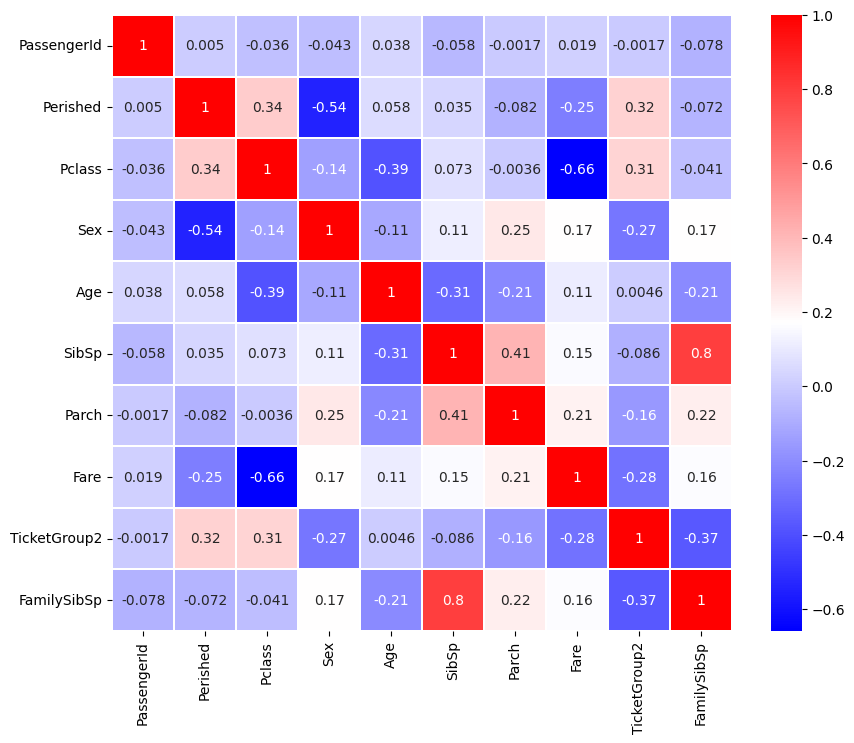

In [991]:
df_numeric = df_train.select_dtypes(include=['number'])
sns.heatmap(df_numeric.corr(),annot=True,cmap='bwr',linewidths=0.2)
fig=plt.gcf()
fig.set_size_inches(10,8)
plt.show()

In [992]:
#pclass = pd.concat([df_train['Pclass'], df_test['Pclass']])
#pclass
#pclass_ohe = pd.get_dummies(pclass)
#pclass_ohe
#pclass_ohe_train = pclass_ohe[:891]
#pclass_ohe_train
#pclass_ohe_test = pclass_ohe[891:]
#pclass_ohe_test

#df_train = pd.concat([df_train, pclass_ohe_train], axis=1)
#df_test = pd.concat([df_test, pclass_ohe_test], axis=1)

#df_train.drop('Pclass', axis=1, inplace=True)
#df_test.drop('Pclass', axis=1, inplace=True)

df_train.head()

,PassengerId,Perished,Pclass,Sex,Age,SibSp,Parch,Fare,TicketGroup2,FamilySibSp
0,1,1.0,3,0,22.0,1,0,7.2500,2,0.5
1,2,0.0,1,1,38.0,1,0,71.2833,1,0.5
2,3,0.0,3,1,26.0,0,0,7.9250,2,0.0
3,4,0.0,1,1,35.0,1,0,53.1000,1,0.5
4,5,1.0,3,0,35.0,0,0,8.0500,2,0.0


##2. ベースラインモデルの構築

In [993]:
X = df_train.iloc[:, 2:].values
y = df_train.iloc[:, 1].values

df_test.drop('Perished', axis=1, inplace=True)
X_test = df_test.iloc[:, 1:].values
df_test.isnull().sum()

PassengerId     0
Pclass          0
Sex             0
Age             0
SibSp           0
Parch           0
Fare            0
TicketGroup2    0
FamilySibSp     0
dtype: int64

In [994]:
df_train

,PassengerId,Perished,Pclass,Sex,Age,SibSp,Parch,Fare,TicketGroup2,FamilySibSp
0,1,1.0,3,0,22.000000,1,0,7.2500,2,0.50
1,2,0.0,1,1,38.000000,1,0,71.2833,1,0.50
2,3,0.0,3,1,26.000000,0,0,7.9250,2,0.00
3,4,0.0,1,1,35.000000,1,0,53.1000,1,0.50
4,5,1.0,3,0,35.000000,0,0,8.0500,2,0.00
...,...,...,...,...,...,...,...,...,...,...
886,887,1.0,2,0,27.000000,0,0,13.0000,2,0.00
887,888,0.0,1,1,19.000000,0,0,30.0000,2,0.00
888,889,1.0,3,1,16.906145,1,2,23.4500,1,0.25
889,890,0.0,1,0,26.000000,0,0,30.0000,2,0.00


In [995]:
df_test

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,TicketGroup2,FamilySibSp
0,892,3,0,34.500000,0,0,7.8292,2,0.000000
1,893,3,1,47.000000,1,0,7.0000,2,0.500000
2,894,2,0,62.000000,0,0,9.6875,2,0.000000
3,895,3,0,27.000000,0,0,8.6625,2,0.000000
4,896,3,1,22.000000,1,1,12.2875,1,0.333333
...,...,...,...,...,...,...,...,...,...
413,1305,3,0,28.421211,0,0,8.0500,2,0.000000
414,1306,1,1,39.000000,0,0,108.9000,1,0.000000
415,1307,3,0,38.500000,0,0,7.2500,2,0.000000
416,1308,3,0,28.421211,0,0,8.0500,2,0.000000


In [996]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=42)

# 標準化
sc = StandardScaler()
sc.fit(X_train)
sc.fit(X_valid)

X_train_std = sc.transform(X_train)
X_valid_std = sc.transform(X_valid)

# Cross Validation

In [997]:
#from catboost import CatBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier

from sklearn.model_selection import cross_val_score
from sklearn import metrics

In [998]:
#この組み合わせがBest
models = [
    ("GBM", GradientBoostingClassifier(random_state=42)),
    #("Histogram Boosting", HistGradientBoostingClassifier(random_state=42)),
    ("SVM", SVC(probability=True, random_state=42)),
    #("XGBoost", XGBClassifier(random_state=42)),
    #("Catboost", CatBoostClassifier(verbose=0, random_state=42)),
    ("Regression", LogisticRegression(max_iter=600, random_state=42)),
    #("Random Forest", RandomForestClassifier(random_state=42)),
    #("K-Nearest", KNeighborsClassifier()),
    ("LGBMClassifier",LGBMClassifier(boosting_type='goss',random_state=42, verbose=-1)),
    #("MLPClassifier", MLPClassifier(hidden_layer_sizes=(100, 100, 10), random_state=42))
]

for i, (name, model) in enumerate(models, 1):
    model.fit(X_train_std, y_train)
    acc = cross_val_score(model, X_train_std, y_train, cv=3).mean()
    print(f"{round(acc*1000)/10} % - {name}")

82.2 % - GBM
83.3 % - SVM
81.2 % - Regression
83.5 % - LGBMClassifier


In [999]:
voting_clf = VotingClassifier(estimators=models, voting='soft')
voting_clf.fit(X_train_std, y_train)
#acc = cross_val_score(voting_clf, X_train_std, y_train, cv=5).mean()
#acc = cross_val_score(voting_clf, X_train_std, y_train, cv=5).argmax(axis=1)
acc_std = cross_val_score(voting_clf, X_train_std, y_train, cv=5).max()
#acc = cross_val_score(voting_clf, X_train, y_train, cv=5).max()

print(round(acc_std*1000)/10, "% - Voting")
#print(round(acc*1000)/10, "% - Voting")

90.4 % - Voting


#5. モデルのアンサンブリング

In [1000]:
# 標準化
sc_test = StandardScaler()
sc_test.fit(X_test)
X_test_std = sc_test.transform(X_test)

In [1001]:
pred= voting_clf.predict(X_test_std).astype(int)
#pred= voting_clf.predict(X_test).astype(int)

pred_kaggle = np.array(pred)

#for k np.range(pred.size):
for k in range(0,len(pred_kaggle)):
  if pred_kaggle[k] == 1:
    pred_kaggle[k] = 0
  else :
    pred_kaggle[k] = 1

pred_kaggle

array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [1002]:
#lr_pred = lr.predict_proba(X_test_std)
#mlpc_pred = mlpc.predict_proba(X_test_std)
#rfc_pred = rfc.predict_proba(X_test)
#gbc_pred = gbc.predict_proba(X_test)
#lgb_pred = lgbmc.predict_proba(X_test)

#pred_proba = (rfc_pred + lr_pred + mlpc_pred + gbc_pred + lgb_pred) / 5
#pred = pred_proba.argmax(axis=1)

#pred_kaggle = np.array(pred)

#for k in range(0,len(pred_kaggle)):
#  if pred_kaggle[k] == 1:
#    pred_kaggle[k] = 0
#  else :
#    pred_kaggle[k] = 1
#
#pred_kaggle

#6. 予測の出力・提出

In [1003]:
 # 読み込むデータが格納されたディレクトリのパス，必要に応じて変更の必要あり
#path = '/content/drive/My Drive/Colab Notebooks/GCI_2024_Summer/Competitions/competition_1/'
path = "/content/drive/MyDrive/data/"
submission = pd.read_csv(path + 'gender_submission.csv')
submission

submission_kaggle = pd.read_csv(path + 'gender_submission.csv')
submission_kaggle

,PassengerId,Perished
0,892,1
1,893,0
2,894,1
3,895,1
4,896,0
...,...,...
413,1305,1
414,1306,0
415,1307,1
416,1308,1


In [1004]:
pred.shape

(418,)

In [1005]:
submission['Perished'] = pred
submission

,PassengerId,Perished
0,892,1
1,893,1
2,894,1
3,895,1
4,896,0
...,...,...
413,1305,1
414,1306,0
415,1307,1
416,1308,1


In [1006]:
submission_kaggle['Survived'] = pred_kaggle
submission_kaggle.drop('Perished', axis=1, inplace=True)
submission_kaggle

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [1007]:
# JupyterLabなどローカルで作業する場合
# パスは必要に応じて変更の必要あり
#submission.to_csv('/content/drive/My Drive/Colab Notebooks/GCI_2024_Summer/Competitions/competition_1/submission.csv', index=False)
submission.to_csv('/content/drive/MyDrive/data/submission.csv', index=False)
submission_kaggle.to_csv('/content/drive/MyDrive/data/submission_kaggle.csv', index=False)

In [1008]:
# Google Drive・Google Colaboratoryで作業する場合
submission.to_csv('submission.csv',index=False)
submission_kaggle.to_csv('submission_kaggle.csv',index=False)

from google.colab import files
files.download('submission.csv')
files.download('submission_kaggle.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>